# Imports

In [49]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase
using Distances

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [50]:
data = CSV.read("data.csv")

,1,2,3,4,5,6,7,8,9,10,11
,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64
1,3.919,2.6909,0,0,0,0,0,31.4,2,0,0
2,4.17,2.1144,0,0,0,0,0,30.8,1,1,0
3,3.932,3.2512,0,0,0,0,0,26.7,2,4,0
4,3.0,2.7098,0,0,0,0,0,20.0,0,2,0
5,4.236,3.3944,0,0,0,0,0,29.4,2,4,0
6,4.236,3.4286,0,0,0,0,0,28.6,2,4,0
7,5.0,5.0476,1,0,0,0,0,11.1,0,3,0
8,4.525,3.8301,0,0,0,0,0,31.6,3,2,0
9,4.596,3.0777,0,0,0,0,2,44.4,2,0,0


Look at class labels to see if dataset is imbalanced

In [51]:
label_counts = countmap(data[:Class])

Dict{String,Int64} with 2 entries:
  "RB"  => 356
  "NRB" => 699

In [52]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.33744075829383885
 0.6625592417061611

Get data ready for training

In [53]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,1,4.78264,2.0,4.828,6.496,,,Float64
2,2,3.06951,0.8039,3.0463,9.1775,,,Float64
3,3,0.716588,0,0.0,12,,,Int64
4,4,0.042654,0,0.0,3,,,Int64
5,5,0.980095,0,0.0,36,,,Int64
6,6,0.290047,0,0.0,13,,,Int64
7,7,1.64645,0,1.0,18,,,Int64
8,8,37.0556,0.0,37.5,60.7,,,Float64
9,9,1.3763,0,1.0,24,,,Int64


In [54]:
coerce!(data, :Class=>Multiclass)
schema(data)

┌─────────┬─────────────────────────────────┬───────────────┐
│ _.names │ _.types                         │ _.scitypes    │
├─────────┼─────────────────────────────────┼───────────────┤
│ 1       │ Float64                         │ Continuous    │
│ 2       │ Float64                         │ Continuous    │
│ 3       │ Int64                           │ Count         │
│ 4       │ Int64                           │ Count         │
│ 5       │ Int64                           │ Count         │
│ 6       │ Int64                           │ Count         │
│ 7       │ Int64                           │ Count         │
│ 8       │ Float64                         │ Continuous    │
│ 9       │ Int64                           │ Count         │
│ 10      │ Int64                           │ Count         │
│ 11      │ Int64                           │ Count         │
│ 12      │ Float64                         │ Continuous    │
│ 13      │ Float64                         │ Continuous    │
│ 14    

In [55]:
y, X = unpack(data, ==(:Class), colname->true)

(CategoricalValue{String,UInt32}["RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB"  …  "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB"], 1055×41 DataFrame. Omitted printing of 33 columns
│ Row  │ 1       │ 2       │ 3     │ 4     │ 5     │ 6     │ 7     │ 8       │
│      │ Float64 │ Float64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Float64 │
├──────┼─────────┼─────────┼───────┼───────┼───────┼───────┼───────┼─────────┤
│ 1    │ 3.919   │ 2.6909  │ 0     │ 0     │ 0     │ 0     │ 0     │ 31.4    │
│ 2    │ 4.17    │ 2.1144  │ 0     │ 0     │ 0     │ 0     │ 0     │ 30.8    │
│ 3    │ 3.932   │ 3.2512  │ 0     │ 0     │ 0     │ 0     │ 0     │ 26.7    │
│ 4    │ 3.0     │ 2.7098  │ 0     │ 0     │ 0     │ 0     │ 0     │ 20.0    │
│ 5    │ 4.236   │ 3.3944  │ 0     │ 0     │ 0     │ 0     │ 0     │ 29.4    │
│ 6    │ 4.236   │ 3.4286  │ 0     │ 0     │ 0     │ 0     │ 0     │ 28.6    │
│ 7    │ 5.0     │ 5.0476  │ 1     │ 0     │ 0     │ 0     │ 0     │ 11.

Partition train and test data accoring to class labels

In [56]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class])) # gives 70:30 split

([465, 562, 278, 619, 161, 972, 782, 321, 537, 760  …  12, 913, 471, 13, 1006, 802, 112, 840, 744, 261], [196, 586, 245, 77, 1028, 432, 215, 987, 137, 411  …  975, 610, 886, 848, 731, 1024, 805, 500, 659, 415])

In [57]:
train_counts = countmap(data[train,:Class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.33739837398373984
 0.6626016260162602

In [58]:
test_counts = countmap(data[test,:Class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.33753943217665616
 0.6624605678233438

In [59]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @574.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [60]:
models(matching(X,y))

6-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )
 (name = RandomForestClassifier, package_name = ScikitLearn, ... )

In [61]:
@load KNNClassifier

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @138

## K Nearest Neighbors
* Use different values of k.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/
1. https://github.com/KristofferC/NearestNeighbors.jl

#### No Pre-Processing

In [62]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @068

In [63]:
KNN = machine(knn, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @068`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{KNNClassifier} @956 trained 0 times.
  args: 
    1:	Source @589 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @992 ⏎ `AbstractArray{Multiclass{2},1}`


In [64]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @956.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @956 trained 1 time.
  args: 
    1:	Source @589 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @992 ⏎ `AbstractArray{Multiclass{2},1}`


In [65]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 1.68          │ [1.92, 1.09, 2.12, 2.11, 1.73, 1.12]       │
│ acc           │ 0.826         │ [0.807, 0.858, 0.801, 0.807, 0.835, 0.846] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[0.223, 0.916, ..., 2.22e-16], [0.223, 0.511, ..., 0.511], [2.22e-16, 0.223, ..., 2.22e-16], [2.22e-16, 0.916, ..., 1.61], [0.223, 2.22e-16, ..., 0.223], [0.223, 2.22e-16, ..., 0.223]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [66]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 880
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,)

#### With Pre-Processing

In [67]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @278

In [68]:
KNN = machine(knn, X_stand, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @278`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{KNNClassifier} @593 trained 0 times.
  args: 
    1:	Source @033 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @432 ⏎ `AbstractArray{Multiclass{2},1}`


In [69]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @593.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @593 trained 1 time.
  args: 
    1:	Source @033 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @432 ⏎ `AbstractArray{Multiclass{2},1}`


In [70]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 1.12          │ [1.12, 1.67, 0.659, 0.667, 1.53, 1.08]     │
│ acc           │ 0.85          │ [0.835, 0.841, 0.875, 0.881, 0.801, 0.869] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 0.511], [0.223, 2.22e-16, ..., 1.61], [2.22e-16, 0.916, ..., 1.61], [2.22e-16, 2.22e-16, ..., 2.22e-16], [0.511, 0.223, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [71]:
# evaluate!(KNN, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [72]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 880
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,)

### GridSearch / RandomSearch

#### Euclidean

In [73]:
knn_grid = KNNClassifier()

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @291

In [74]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=10, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [100]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1],
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Chebyshev(),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @571],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @598

In [101]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=ProbabilisticTunedModel{Grid,…} @598`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{ProbabilisticTunedModel{Grid,…}} @846 trained 0 times.
  args: 
    1:	Source @753 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @544 ⏎ `AbstractArray{Multiclass{2},1}`


In [102]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @846.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=Resampler{CV,…} @665`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
Evaluating over 10 metamodels:   0%[>                        ]  ETA: N/A┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @092`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where 

Machine{ProbabilisticTunedModel{Grid,…}} @846 trained 1 time.
  args: 
    1:	Source @753 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @544 ⏎ `AbstractArray{Multiclass{2},1}`


In [103]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @907,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 738
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [104]:
best.best_model

KNNClassifier(
    K = 4,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @907

#### Manhattan

In [105]:
knn_grid = KNNClassifier(metric=Chebyshev())

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @580

In [106]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=10, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [107]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1], 
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Chebyshev(),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @571],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @764

In [108]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=ProbabilisticTunedModel{Grid,…} @764`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{ProbabilisticTunedModel{Grid,…}} @576 trained 0 times.
  args: 
    1:	Source @831 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @985 ⏎ `AbstractArray{Multiclass{2},1}`


In [109]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @576.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=Resampler{CV,…} @063`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
Evaluating over 10 metamodels:   0%[>                        ]  ETA: N/A┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @390`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where 

Machine{ProbabilisticTunedModel{Grid,…}} @576 trained 1 time.
  args: 
    1:	Source @831 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @985 ⏎ `AbstractArray{Multiclass{2},1}`


In [110]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @657,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 738
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [111]:
best.best_model

KNNClassifier(
    K = 4,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @657

### Learning Curve

In [112]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.9, 0.7027027027027027)
(d, train_metric, valid_metric) = (15, 0.8666666666666667, 0.7027027027027027)
(d, train_metric, valid_metric) = (20, 0.8, 0.7027027027027027)
(d, train_metric, valid_metric) = (25, 0.76, 0.7027027027027027)
(d, train_metric, valid_metric) = (30, 0.8333333333333334, 0.722972972972973)
(d, train_metric, valid_metric) = (35, 0.8285714285714286, 0.7162162162162162)
(d, train_metric, valid_metric) = (40, 0.875, 0.722972972972973)
(d, train_metric, valid_metric) = (45, 0.8888888888888888, 0.7364864864864865)
(d, train_metric, valid_metric) = (50, 0.86, 0.7027027027027027)
(d, train_metric, valid_metric) = (55, 0.8, 0.7297297297297297)
(d, train_metric, valid_metric) = (60, 0.7833333333333333, 0.7094594594594594)
(d, train_metric, valid_metric) = (65, 0.7538461538461538, 0.7094594594594594)
(d, train_metric, valid_metric) = (70, 0.7428571428571429, 0.6824324324324325)
(d, train_metric, valid_metric) = (75, 0.7333333333333333, 0.

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (120, 0.825, 0.7027027027027027)
(d, train_metric, valid_metric) = (125, 0.832, 0.6891891891891891)
(d, train_metric, valid_metric) = (130, 0.8384615384615385, 0.7094594594594594)
(d, train_metric, valid_metric) = (135, 0.8444444444444444, 0.6959459459459459)
(d, train_metric, valid_metric) = (140, 0.8428571428571429, 0.7162162162162162)
(d, train_metric, valid_metric) = (145, 0.8482758620689655, 0.7094594594594594)
(d, train_metric, valid_metric) = (150, 0.8466666666666667, 0.7094594594594594)
(d, train_metric, valid_metric) = (155, 0.8516129032258064, 0.7162162162162162)
(d, train_metric, valid_metric) = (160, 0.8625, 0.7094594594594594)
(d, train_metric, valid_metric) = (165, 0.8484848484848485, 0.7162162162162162)
(d, train_metric, valid_metric) = (170, 0.8470588235294118, 0.7162162162162162)
(d, train_metric, valid_metric) = (175, 0.8457142857142858, 0.7162162162162162)
(d, train_metric, valid_metric) = (180, 0.85, 0.7162162162162162)
(d, train_me

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (340, 0.8647058823529412, 0.75)
(d, train_metric, valid_metric) = (345, 0.863768115942029, 0.75)
(d, train_metric, valid_metric) = (350, 0.8628571428571429, 0.75)
(d, train_metric, valid_metric) = (355, 0.8647887323943662, 0.7567567567567568)
(d, train_metric, valid_metric) = (360, 0.8638888888888889, 0.7567567567567568)
(d, train_metric, valid_metric) = (365, 0.863013698630137, 0.7635135135135135)
(d, train_metric, valid_metric) = (370, 0.8675675675675676, 0.7635135135135135)
(d, train_metric, valid_metric) = (375, 0.872, 0.7702702702702703)
(d, train_metric, valid_metric) = (380, 0.8736842105263158, 0.7702702702702703)
(d, train_metric, valid_metric) = (385, 0.8727272727272727, 0.7702702702702703)
(d, train_metric, valid_metric) = (390, 0.8743589743589744, 0.777027027027027)
(d, train_metric, valid_metric) = (395, 0.8810126582278481, 0.7905405405405406)
(d, train_metric, valid_metric) = (400, 0.88, 0.7972972972972973)
(d, train_metric, valid_metric) 

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (435, 0.8804597701149425, 0.8040540540540541)
(d, train_metric, valid_metric) = (440, 0.8818181818181818, 0.8040540540540541)
(d, train_metric, valid_metric) = (445, 0.8786516853932584, 0.8040540540540541)
(d, train_metric, valid_metric) = (450, 0.88, 0.8040540540540541)
(d, train_metric, valid_metric) = (455, 0.8813186813186813, 0.8040540540540541)
(d, train_metric, valid_metric) = (460, 0.8782608695652174, 0.8040540540540541)
(d, train_metric, valid_metric) = (465, 0.8795698924731182, 0.7972972972972973)
(d, train_metric, valid_metric) = (470, 0.8808510638297873, 0.8040540540540541)
(d, train_metric, valid_metric) = (475, 0.8778947368421053, 0.8040540540540541)
(d, train_metric, valid_metric) = (480, 0.8833333333333333, 0.8040540540540541)
(d, train_metric, valid_metric) = (485, 0.8865979381443299, 0.8040540540540541)
(d, train_metric, valid_metric) = (490, 0.8857142857142857, 0.8040540540540541)


┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (495, 0.8868686868686869, 0.8040540540540541)
(d, train_metric, valid_metric) = (500, 0.884, 0.8040540540540541)
(d, train_metric, valid_metric) = (505, 0.8851485148514852, 0.7972972972972973)
(d, train_metric, valid_metric) = (510, 0.8862745098039215, 0.7972972972972973)
(d, train_metric, valid_metric) = (515, 0.8854368932038835, 0.7972972972972973)
(d, train_metric, valid_metric) = (520, 0.8865384615384615, 0.8175675675675675)
(d, train_metric, valid_metric) = (525, 0.8876190476190476, 0.8175675675675675)
(d, train_metric, valid_metric) = (530, 0.8886792452830189, 0.8175675675675675)
(d, train_metric, valid_metric) = (535, 0.8878504672897196, 0.8108108108108109)
(d, train_metric, valid_metric) = (540, 0.8870370370370371, 0.8108108108108109)
(d, train_metric, valid_metric) = (545, 0.8899082568807339, 0.8108108108108109)
(d, train_metric, valid_metric) = (550, 0.8909090909090909, 0.8108108108108109)
(d, train_metric, valid_metric) = (555, 0.89189189189

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (560, 0.8964285714285715, 0.8175675675675675)
(d, train_metric, valid_metric) = (565, 0.8955752212389381, 0.8175675675675675)
(d, train_metric, valid_metric) = (570, 0.8947368421052632, 0.8175675675675675)
(d, train_metric, valid_metric) = (575, 0.8973913043478261, 0.7972972972972973)
(d, train_metric, valid_metric) = (580, 0.896551724137931, 0.7972972972972973)
(d, train_metric, valid_metric) = (585, 0.8957264957264958, 0.7972972972972973)
(d, train_metric, valid_metric) = (590, 0.8932203389830509, 0.7972972972972973)


┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @657`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(10:5:590, Any[0.9, 0.8666666666666667, 0.8, 0.76, 0.8333333333333334, 0.8285714285714286, 0.875, 0.8888888888888888, 0.86, 0.8  …  0.8899082568807339, 0.8909090909090909, 0.8918918918918919, 0.8964285714285715, 0.8955752212389381, 0.8947368421052632, 0.8973913043478261, 0.896551724137931, 0.8957264957264958, 0.8932203389830509], Any[0.7027027027027027, 0.7027027027027027, 0.7027027027027027, 0.7027027027027027, 0.722972972972973, 0.7162162162162162, 0.722972972972973, 0.7364864864864865, 0.7027027027027027, 0.7297297297297297  …  0.8108108108108109, 0.8108108108108109, 0.8108108108108109, 0.8175675675675675, 0.8175675675675675, 0.8175675675675675, 0.7972972972972973, 0.7972972972972973, 0.7972972972972973, 0.7972972972972973])

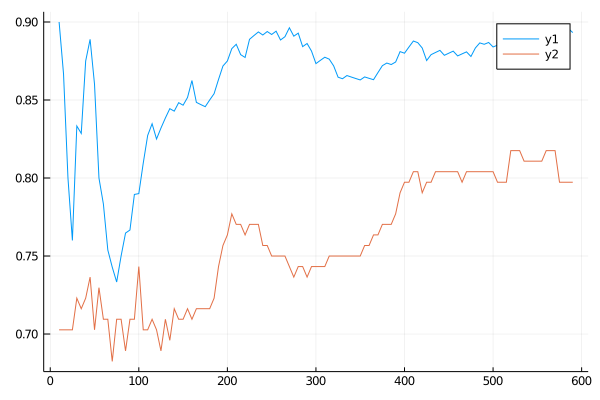

In [113]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

In [114]:
knn_final = KNNClassifier(K=best.best_model.K)

KNNClassifier(
    K = 4,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @094

In [115]:
KNN_Final = machine(knn_final, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @094`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{KNNClassifier} @634 trained 0 times.
  args: 
    1:	Source @100 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @530 ⏎ `AbstractArray{Multiclass{2},1}`


In [116]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @593.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @593 trained 8 times.
  args: 
    1:	Source @033 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @432 ⏎ `AbstractArray{Multiclass{2},1}`


In [117]:
ŷ = MLJ.predict(KNN, X_stand[test,:]);

In [118]:
cross_entropy(ŷ, y[test]) |> mean

1.3989417665622235

In [119]:
acc(ŷ, y[test])

0.8485804416403786

In [120]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='NRB' and positive='RB'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     NRB     │     RB      │
├─────────────┼─────────────┼─────────────┤
│     NRB     │     185     │     23      │
├─────────────┼─────────────┼─────────────┤
│     RB      │     25      │     84      │
└─────────────┴─────────────┴─────────────┘
